# Imports

In [ ]:
%pip install opendatasets --upgrade --quiet
import opendatasets

import random
import os
import shutil
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


In [3]:
# Get data from kaggle
data_url = "https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria"
opendatasets.download(data_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:Your Kaggle Key:Dataset URL: https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria


100%|██████████| 675M/675M [00:19<00:00, 36.3MB/s] 


# Exploring Data
- delete unnecessary data and visualize images

In [6]:
# checking for duplicate data folders
os.rename("cell-images-for-detecting-malaria", "data")
root_path = "data/cell_images/"
img_paths = ['cell_images/Parasitized', 'cell_images/Uninfected', "Parasitized", "Uninfected"]
image_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff')

for img_path in img_paths:
    img_path = root_path + img_path
    if os.path.exists(img_path) and os.path.isdir(img_path):
        image_count = len([f for f in os.listdir(img_path) if f.lower().endswith(image_extensions)])
        print(f"Number of images in {img_path}: {image_count}")
    else:
        print(f"Path does not exist or is already deleted: {img_path}")

# dropping duplicate data folders
delete_path = root_path + "cell_images"
if os.path.exists(delete_path) and os.path.isdir(delete_path):
    shutil.rmtree(delete_path)
    print(f"Deleted folder: {delete_path}")
else:
    print(f"Folder does not exist or is already deleted: {delete_path}")


Number of images in data/cell_images/cell_images/Parasitized: 13779
Number of images in data/cell_images/cell_images/Uninfected: 13779
Number of images in data/cell_images/Parasitized: 13779
Number of images in data/cell_images/Uninfected: 13779
Deleted folder: data/cell_images/cell_images


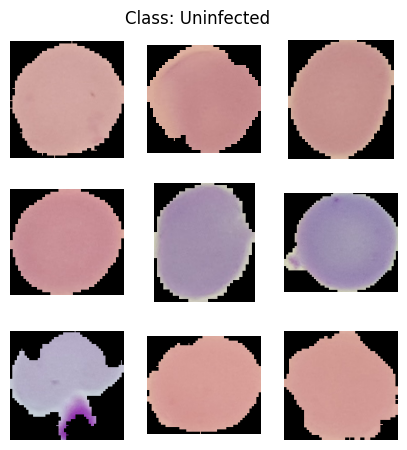

In [24]:
def plot_images_from_dir(path, img_class, num_imgs=9):
    img_filenames = os.listdir(path)

    if len(img_filenames) < num_imgs:
        print(f"Only found {len(img_filenames)} images in {path}.")
        num_imgs = len(img_filenames)

    display_imgs = random.sample(img_filenames, num_imgs)

    fig, axes = plt.subplots(3,3, figsize=(5, 5))        # (rows,cols,figsize) | fig = whole figure | axes == matrix with each element = subplot
    axes = axes.ravel()             # flatten matrix into vector
    fig.suptitle("Class: " + img_class)
    plt.subplots_adjust(top=0.92)

    for i, display_img in enumerate(display_imgs):
        img_path = os.path.join(path, display_img)
        img = Image.open(img_path)
        axes[i].imshow(img)     # show img in ith subplot
        axes[i].axis('off')         # hide axes

uninfected_path = root_path + 'Uninfected'
uninfected_class = 'Uninfected'
plot_images_from_dir(uninfected_path, uninfected_class)

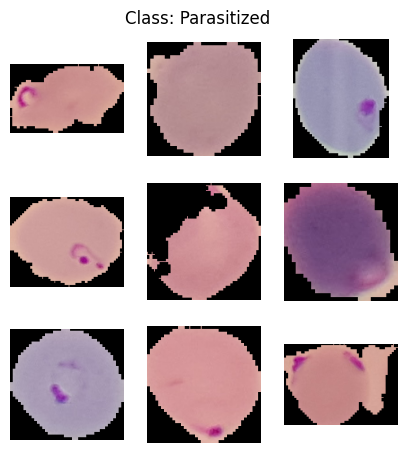

In [25]:
parasitized_path = root_path + 'Parasitized'
parasitized_class = 'Parasitized'
plot_images_from_dir(parasitized_path, parasitized_class)

# Transforming Data
- Apply transformations
- create train and validation sets
- create train and validatation dataloaders

In [14]:
dataset = ImageFolder(root_path, tt.Compose([
    tt.Resize(224),
    tt.RandomCrop(224),
    tt.ToTensor()
]))

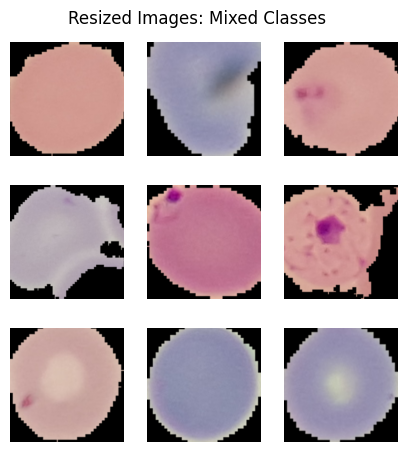

In [45]:
def plot_images_from_dataset(dataset, num_imgs:int = 9):
    n = len(dataset)
    if n < num_imgs:
        print(f"Only found {n} images to display.")
        num_imgs = n

    img_indices = random.sample(range(0, n), num_imgs)

    fig, axes = plt.subplots(3, 3, figsize=(5, 5))  # (rows, cols, figsize)
    axes = axes.ravel()  # Flatten the matrix into a vector
    fig.suptitle("Resized Images: Mixed Classes")
    plt.subplots_adjust(top=0.92)

    for i, img_i in enumerate(img_indices):
        img_tensor = dataset[img_i][0]
        axes[i].imshow(img_tensor.permute((1,2,0)))  # Show the image in the ith subplot
        axes[i].axis('off')  # Hide axes

    plt.show()

# plotting transformed images 
plot_images_from_dataset(dataset)

In [46]:
# Defining validation size
val_pct = 0.1
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size

# creating train-val split
train_ds, val_ds = random_split(dataset, [train_size, val_size])
print(len(train_ds), len(val_ds))


24803 2755


In [69]:
# create data loaders
batch_size = 128
train_dl = DataLoader(train_ds,
                      batch_size,
                      shuffle=True,
                      num_workers=4,
                      pin_memory=True)

val_dl = DataLoader(val_ds,
                      batch_size,
                      num_workers=4,
                      pin_memory=True)

# GPU Utilities

1. **Function**: to return the device: **GPU** if available, otherwise **CPU**.

2. **Function**: to take a batch of data and load each image in it to the specified device.

3. **DataLoader Wrapper Class**
   - Args: a dataloader and device
     - **`__iter__:`** Yields a batch of data after moving it to the device.
     - **`__len__:`** Returns the number of batches in the DataLoader.

In [78]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
print(f"device being used: {to_device(dataset[0][0], device).device}")

train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(val_dl, device)


device being used: cuda:0


# Model and Training Utilties

In [73]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        "calculate loss for a batch of training data"
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        "calculate loss & accuracy for a batch of validation data"
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


device(type='cuda')